## 3.1. Importación de librerías necesarias (valor 0.2)

En esta celda deben estar importadas todas las librerías y funciones que se usarán a lo largo de todo el cuaderno.

$$
\newcommand{\pap}[1]{\left(#1\right)}
\newcommand{\pas}[1]{\left[#1\right]}
\newcommand{\pac}[1]{\left\{#1\right\}}
\newcommand{\pav}[1]{\left\vert#1\right\vert}
\newcommand{\rv}{\vec{r}}
\newcommand{\rb}{\mathbf{r}}
\newcommand{\xb}{\mathbf{x}}
\newcommand{\xv}{\vec{x}}
\newcommand{\xbr}{\bar{x}}
\newcommand{\ome}{\omega}
\newcommand{\lam}{\lambda}
\newcommand{\dd}{\mathrm{d}}
\newcommand{\ee}{\mathrm{e}}
\newcommand{\eps}{\epsilon}
\newcommand{\iun}{\hat{\boldsymbol{\imath}}}
\newcommand{\jun}{\hat{\boldsymbol{\jmath}}}
\newcommand{\pr}{^{\prime}}
\newcommand{\chinu}{\chi_{\nu}^2}
$$

In [1]:
!python -m pip install pyforest
!python -m pip install matplotlib
!python -m pip install scipy


%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import random as rd
from matplotlib import rcParams
from scipy.optimize import curve_fit as cfit
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation 

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13714 sha256=2feb1ffbbf067b4312d7c10c509352e325438bf88f96723a1d9e14a98fc8ca1b
  Stored in directory: /home/jovyan/.cache/pip/wheels/72/b6/6c/b593d021f7e83f481c5208bc23df0084bcfbeb5b141352b882
Successfully built pyforest
     |████████████████████████████████| 12.4 MB 3.2 MB/s eta 0:00:01    |██                              | 737 kB 3.2 MB/s eta 0:00:04
     |████████████████████████████████| 20.2 MB 37.5 MB/s eta 0:00:01B/s eta 0:00:01     |██████████████████████████▍     | 16.6 MB 37.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 26.1 MB 220 kB/s eta 0:00:01    |████████▌                       | 6.9 MB 3.5 MB/s eta 0:00:06


## 3.A. Celda de inicio

La celda que está abajo está completa y sirve como base para el resto del ejercicio. Sin embargo, su funcionamiento correcto depende de las celdas anteriores. Las primeras tres funciones `fU,fK,fH` calculan respectivamente la energía potencial, cinética y mecánica del sistema dependiendo de las variables y parámetros: $\phi_1,\phi_2,\ome_1,\ome_2,m,l$. 

Las siguientes dos funciones apuntan a generar el siguiente conjunto de variables $\pap{\phi_1,\phi_2,\ome_1,\ome_2}$ dados los valores previos, los parámetros $m,l$ y el paso en el tiempo $dt$. Esto lo logra la función `nextvarsRK4` por **método de Runge-Kutta 4** (se estudiará en *Métodos Computacionales*).

La última función `varini` genera aleatoriamente las variables iniciales $\pap{\phi_1,\phi_2,\ome_1,\ome_2}$ de acuerdo a una energía total $E$ y los parámetros $m,l$.

In [2]:
# Esta función calcula la energía potencial total del sistema
fU=lambda ph1,ph2,m,l: -l*(1+m)*np.cos(ph1)-np.cos(ph2)+(1+m)*l+1
# Esta función calcula la energía potencial total del sistema
fK=lambda ph1,ph2,ome1,ome2,m,l: 0.5*(m+1)*l**2*ome1**2+0.5*ome2**2+l*np.cos(ph1-ph2)*ome1*ome2
# # Esta función calcula la energía mecánica total del sistema
fH=lambda ph1,ph2,ome1,ome2,m,l:fU(ph1,ph2,m,l)+fK(ph1,ph2,ome1,ome2,m,l)

def dvar(var,m,l):
        """
        Computes the right-hand side of the Euler-Lagrange equations
        for the double pendulum and returns it as an array.
        t1 - The angle of bob #1.
        t2 - The angle of bob #2.
        w1 - The angular velocity of bob #1.
        w2 - The angular velocity of bob #2.
        Importada de https://github.com/dassencio/double-pendulum/blob/master/dp_lagrangian.py
        con ligeros ajustes
        """
        t1,t2,w1,w2=var
        a1 = (1 / l) * (1 / (m + 1)) * math.cos(t1 - t2)
        a2 = (l / 1) * math.cos(t1 - t2)
        f1 = -(1 / l) * (1 / (m + 1)) * (w2**2) * math.sin(t1 - t2) - \
            (1/ l) * math.sin(t1)
        f2 = l* (w1**2) * math.sin(t1 - t2) - math.sin(t2)
        g1 = (f1 - a1 * f2) / (1 - a1 * a2)
        g2 = (f2 - a2 * f1) / (1 - a1 * a2)
        return np.array([w1, w2, g1, g2])

def nextvarsRK4(varp,m,l,dt):
    """"
    Por método de Runge-Kutta 4 Esta función calcula el siguiente array dado el previo
    y un paso dt
    """
    k1=dt*dvar(varp,m,l)
    k2=dt*dvar(varp+0.5*k1,m,l)
    k3=dt*dvar(varp+0.5*k2,m,l)
    k4=dt*dvar(varp+k3,m,l)
    nextk=varp+(1/6.0)*(k1+2*k2+2*k3+k4)
    return nextk

def randini(E,m,l):
    pi=np.pi
    Umax=2*((1+m)*l+1)
    if E<=0:
        ph1=0
        ph2=0
        ome1=0
        ome2=0
    else:
        al=np.random.rand()
        if E<Umax:
            U=al*E
        else:
            U=al*Umax
        K=E-U
        ph1=np.random.rand()*2*pi-pi
        co2=-l*(1+m)*np.cos(ph1)+(1+m)*l+1-U
        while np.abs(co2)>1:
            ph1=np.random.rand()*2*pi-pi
            co2=-l*(1+m)*np.cos(ph1)+(1+m)*l+1-U
        ph2=math.acos(co2)
        al=np.random.rand()
        if al>0.5:
            ph2=-ph2
        th=np.random.rand()*2*pi-pi
        ome1=math.cos(th)
        ome2=math.sin(th)
        rome=math.sqrt(K/(0.5*(m+1)*l**2*ome1**2+0.5*ome2**2+l*np.cos(ph1-ph2)*ome1*ome2))
        ome1=rome*math.cos(th)
        ome2=rome*math.sin(th)
    return np.array([ph1,ph2,ome1,ome2])
        

## 3.2. Celda de definición de clase **pendulo** (valor 0.3)

En esta celda, el ejercicio será escribir un código que genere la clase (objeto) `pendulo`. Esta clase debe cumplir con los siguientes requisitos:
1. **Argumentos iniciales.** Debe pedir como argumentos iniciales los parámetros $m,l$ y las variables iniciales $\pap{\phi_1,\phi_2,\ome_1,\ome_2}$. **El orden debe ser ese**: $m,l,\phi_1,\phi_2,\ome_1,\ome_2$.
2. **Atributos**. Los atributos pedidos son:
    - Un par de atributos numéricos para los parámetros $m,l$. Estos se llamarán `m` y `l` respectivamente.
    - Un `array` de `numpy` con las variables $\pap{\phi_1,\phi_2,\ome_1,\ome_2}$ (en ese orden). Este se llamará `var`.
    - Tres números para cada una de las tres energías, los cuales se llamarán `K`, `U` y `H` (ver celda **3.1** para saber qué significan).
3. **Función de inicio.** En la función de inicio se deben inicializar todos los atributos antes descritos.
4. **Métodos.** El único método pedido se llamará `muevete` y deberá tener un argumento `dt` para el paso del tiempo. En este método se deben actualizar los siguientes atributos: `var`, `K`, `U` y `H` (de acuerdo al paso `dt`). *Pista:* La función `nextvarsRK4`deberá ser usada para actualizar `var`. Los atributos de energía se deberían actualizar **después** de actualizar `var`. 

In [3]:
class pendulo:
    def __init__(self,m,l,ph1,ph2,ome1,ome2):
        self.m = m
        self.l = l
        self.var=np.array([ph1,ph2,ome1,ome2])
        self.U=fU(self.var[0],self.var[1],self.m,self.l)
        self.K=fK(self.var[0],self.var[1],self.var[2],self.var[3],self.m,self.l)
        self.H=fH(self.var[0],self.var[1],self.var[2],self.var[3],self.m,self.l)
    def muevete(self,dt):
        self.var=nextvarsRK4(self.var,self.m,self.l,dt)
        self.U=fU(self.var[0],self.var[1],self.m,self.l)
        self.K=fK(self.var[0],self.var[1],self.var[2],self.var[3],self.m,self.l)
        self.H=fH(self.var[0],self.var[1],self.var[2],self.var[3],self.m,self.l)

## 3.3. Creación de varios objetos **pendulo** (valor 0.2)

La siguiente celda está casi completa, solo falta un pequeño pedazo el cual está después del comentario encerrado por símbolos de exclamación (`#!!!!!`). Sin embargo, su funcionamiento correcto depende de las celdas anteriores. Note que se ha iniciado una lista vacía llamada `pendl`. El objetivo será que usted cree 401 objetos de la clase `pendulo` y los agregue a la lista `pendl` (cada elemento de la lista será un objeto de esa clase).

El resto de la celda está completo y lo que hará será generar una lista bidimensional (según el tiempo y los 401 péndulos) de las variables $\phi_1,\phi_2,\ome_1,\ome_2,U,K$. Note el uso del método `muevete` casi al final.

In [20]:
##########################
# Se definen parámetros: Energía, m, l, y dt
##########################
E,m,l,dt=6.1,1,1,5e-2
############################
# Se establece el número de péndulos y el número de pasos en el tiempo
###########################
npen,nt=401,101
############################################################################
# Se inicializa la lista pendl
############################################################################
pendl=[]

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Se inicializan npen péndulos dobles todos con la misma energía total y los
# mismos parámetros m,l. Estos objetos deben agregarse a la lista pendl. 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
i=0
while i < 401: 
    param=randini(E,m,l)
    penduloNuevo=pendulo(m,l,param[0],param[1],param[2],param[3])
    pendl.append(penduloNuevo)
    i=i+1
    



############################################################################
# Lo que queda de la celda está completo. 
#Lo que harán estas líneas de código será crear 6 listas bidimensionales 
# ph1r,ph2r,ome1r,ome2r,Ur,Kr que definan las variables ph1,ph2,ome1,ome2,U,K 
# en función del tiempo y para cada uno de los 401 péndulos. 
#Es una operación que requiere de un muy buen manejo de listas y por eso no se dejó como ejercicio.
############################################################################ 
# Inicialización
############################################################################
ph1r,ph2r,ome1r,ome2r,Ur,Kr=[[]]*6
############################################################################
# Funciones que ayudarán a escribir el resto del código de forma más eficiente
# La función updatelist es la que agrega los nuevos valores.
############################################################################
fadd=lambda ls,x:ls+[x]
def updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr):
    ph1l,ph2l,ome1l,ome2l,Ul,Kl=[[]]*6
    for i in range(npen):
# Note el uso de .var .U .K para extraer los atributos de cada péndulo
        var=list(pendl[i].var)+[pendl[i].U,pendl[i].K]
        listl=(ph1l,ph2l,ome1l,ome2l,Ul,Kl)
        ph1l,ph2l,ome1l,ome2l,Ul,Kl=[fadd(listl[j],var[j]) for j in range(6)]
    listl=(ph1r,ph2r,ome1r,ome2r,Ur,Kr)
    var=(ph1l,ph2l,ome1l,ome2l,Ul,Kl)
    return tuple([fadd(listl[j],var[j]) for j in range(6)])
#############################################################################
# Se anotan los valores iniciales
#############################################################################
ph1r,ph2r,ome1r,ome2r,Ur,Kr=updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr)
#############################################################################
# Se mueven los péndulos y se anotan los nuevos valores en el tiempo
# note el uso de .muevete
#############################################################################
for t in range(nt-1):
    for i in range(npen):
        pendl[i].muevete(dt)
    ph1r,ph2r,ome1r,ome2r,Ur,Kr=updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr)

## 3.B. Gráfica de ejemplo

La celda que está abajo está completa y sirve como base para algunos puntos siguientes. Sin embargo, su funcionamiento correcto depende de las celdas anteriores. 

La celda muestra la imagen final de la primera animación que se desea hacer. En esta celda se usa un parámetro `k` (número de recuadro) que le servirá para definir la función `animate` más adelante. También le ayuda a dejar fijos los parámetros de la gráfica para que la animación sea exitosa. 

**Nota importante:**
Note que el título contiene las iniciales del docente y las cifras $00$. En los archivos `.gif` de salida de las animaciones, **estas letras y números deberán cambiarse por las iniciales del estudiante y los últimos dos dígitos del código**. Esto se hace para confirmar que sí fue usted el que generó el código.

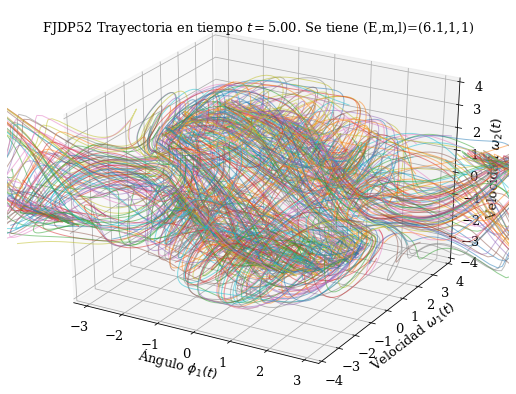

In [21]:
rcParams['font.family'] = 'serif'
pp=np.pi
fs=13
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection='3d')
k=nt
for kk in range(npen):
    x=[ph1r[i][kk] for i in range(k)]
    y=[ome1r[i][kk] for i in range(k)]
    z=[ome2r[i][kk] for i in range(k)]
    ax.plot(x,y,z,lw=1,alpha=0.5)
ax.set_zlim(-4,4)
ax.set_xlim(-pp-0.1,pp+0.1)
ax.set_ylim(-4,4)
ax.set_title("FJDP52 Trayectoria en tiempo $t=${0:0.2f}. Se tiene (E,m,l)=({1},{2},{3})"\
.format((k-1)*dt,E,m,l),fontsize=fs)
ax.set_xlabel("Ángulo $\phi_1(t)$",fontsize=fs)
ax.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
ax.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
ax.set_zlabel("Velocidad $\omega_2(t)$",fontsize=fs)
ax.tick_params(labelsize=fs)


## 3.4. Animación con $(E,m,l)=(6.1,1,1)$ (valor 0.3)

En esta celda usted debe generar un código que guarde una animación en un archivo `.gif` tal como se muestra en el archivo compartido `pendulum6-1.gif`. Los parámetros gráficos ya están definidos en la celda previa. El número de recuadros deberá ser 101 y el tiempo entre recuadros deberá ser 100 ms.

*Advertencia:*
La generación de este archivo puede tardar varios minutos. Debido a esto, se aconseja que primero haga una prueba con pocos recuadros para asegurarse de que se está comportando bien.

**Nota importante:**
Note que en el archivo compartido `pendulum6-1.gif` el título contiene las iniciales del docente y las cifras $00$. En los archivos `.gif` de salida de las animaciones, **estas letras y números deberán cambiarse por las iniciales del estudiante y los últimos dos dígitos del código**. El nombre de su archivo de salida también deberá incluir al final estas iniciales y dígitos.

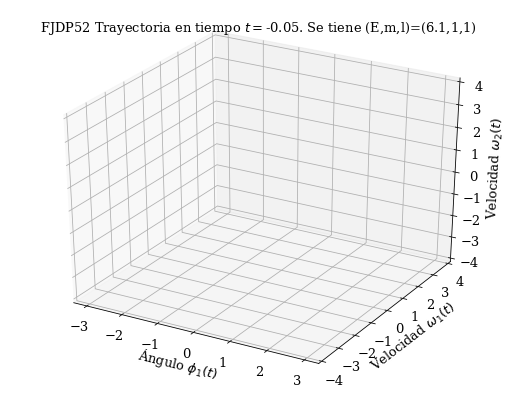

In [6]:
fs=13
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.add_subplot(111,projection='3d')
def animate(k):
    ax1.clear()
    for kk in range(npen):
        x=[ph1r[i][kk] for i in range(k)]
        y=[ome1r[i][kk] for i in range(k)]
        z=[ome2r[i][kk] for i in range(k)]
        ax1.plot(x,y,z,lw=1,alpha=0.5)
    ax1.set_zlim(-4,4)
    ax1.set_xlim(-pp-0.1,pp+0.1)
    ax1.set_ylim(-4,4)
    ax1.set_title("FJDP52 Trayectoria en tiempo $t=${0:0.2f}. Se tiene (E,m,l)=({1},{2},{3})"\
    .format((k-1)*dt,E,m,l),fontsize=fs)
    ax1.set_xlabel("Ángulo $\phi_1(t)$",fontsize=fs)
    ax1.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
    ax1.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
    ax1.set_zlabel("Velocidad $\omega_2(t)$",fontsize=fs)
    ax1.tick_params(labelsize=fs)

ani = FuncAnimation(fig1,animate,frames=101,interval=100,repeat=True)
ani.save('FJDP52pendulum6-1.gif', writer='imagemagick')

## 3.5. Animación con $(E,m,l)=(0.1,1,1)$ (valor 0.2)

En esta celda usted debe repetir los pasos de los puntos **3.3** y **3.4** pero ahora apuntando a generar un archivo con una animación como la que está en el archivo compartido `pendulum0-1.gif`. Los cambios que usted debe hacer respecto al caso anterior son pocos:
1. Cambie el valor de `E` a 0.1
2. Los límites de la gráfica `zlim` y `ylim` deberán ser $\pap{-0.5,0.5}$
3. Los límites de la gráfica `xlim` deberán ser $\pap{-0.3,0.3}$ 

Al igual que en el caso anterior se recomienda hacer un ensayo con pocos recuadros. Igualmente, el título y el nombre de archivo deberán contener las iniciales del estudiante y los últimos dos dígitos del código.

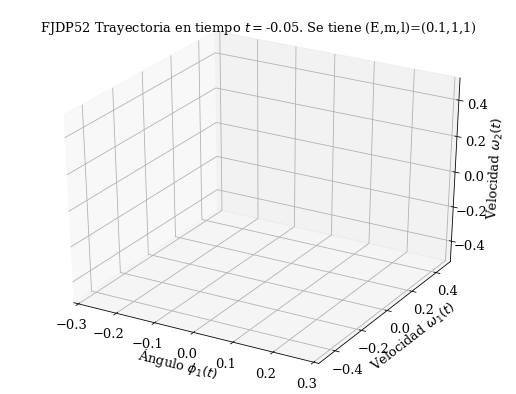

In [7]:
#1. Redefiniendo valor inicial de E
##########################
# Se definen parámetros: Energía, m, l, y dt
##########################
E,m,l,dt=0.1,1,1,5e-2
############################
# Se establece el número de péndulos y el número de pasos en el tiempo
###########################
npen,nt=401,101
############################################################################
# Se inicializa la lista pendl
############################################################################
pendl=[]

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Se inicializan npen péndulos dobles todos con la misma energía total y los
# mismos parámetros m,l. Estos objetos deben agregarse a la lista pendl. 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
i=0
while i < 401: 
    param=randini(E,m,l)
    penduloNuevo=pendulo(m,l,param[0],param[1],param[2],param[3])
    pendl.append(penduloNuevo)
    i=i+1
    



############################################################################
# Lo que queda de la celda está completo. 
#Lo que harán estas líneas de código será crear 6 listas bidimensionales 
# ph1r,ph2r,ome1r,ome2r,Ur,Kr que definan las variables ph1,ph2,ome1,ome2,U,K 
# en función del tiempo y para cada uno de los 401 péndulos. 
#Es una operación que requiere de un muy buen manejo de listas y por eso no se dejó como ejercicio.
############################################################################ 
# Inicialización
############################################################################
ph1r,ph2r,ome1r,ome2r,Ur,Kr=[[]]*6
############################################################################
# Funciones que ayudarán a escribir el resto del código de forma más eficiente
# La función updatelist es la que agrega los nuevos valores.
############################################################################
fadd=lambda ls,x:ls+[x]
def updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr):
    ph1l,ph2l,ome1l,ome2l,Ul,Kl=[[]]*6
    for i in range(npen):
# Note el uso de .var .U .K para extraer los atributos de cada péndulo
        var=list(pendl[i].var)+[pendl[i].U,pendl[i].K]
        listl=(ph1l,ph2l,ome1l,ome2l,Ul,Kl)
        ph1l,ph2l,ome1l,ome2l,Ul,Kl=[fadd(listl[j],var[j]) for j in range(6)]
    listl=(ph1r,ph2r,ome1r,ome2r,Ur,Kr)
    var=(ph1l,ph2l,ome1l,ome2l,Ul,Kl)
    return tuple([fadd(listl[j],var[j]) for j in range(6)])
#############################################################################
# Se anotan los valores iniciales
#############################################################################
ph1r,ph2r,ome1r,ome2r,Ur,Kr=updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr)
#############################################################################
# Se mueven los péndulos y se anotan los nuevos valores en el tiempo
# note el uso de .muevete
#############################################################################
for t in range(nt-1):
    for i in range(npen):
        pendl[i].muevete(dt)
    ph1r,ph2r,ome1r,ome2r,Ur,Kr=updatelist(ph1r,ph2r,ome1r,ome2r,Ur,Kr)
    
#2. Generando animación
fs=13
fig2 = plt.figure(figsize=(9,7))
ax1 = fig2.add_subplot(111,projection='3d')
def animate(k):
    ax1.clear()
    for kk in range(npen):
        x=[ph1r[i][kk] for i in range(k)]
        y=[ome1r[i][kk] for i in range(k)]
        z=[ome2r[i][kk] for i in range(k)]
        ax1.plot(x,y,z,lw=1,alpha=0.5)
    ax1.set_zlim(-0.5,0.5)
    ax1.set_xlim(-0.3,0.3)
    ax1.set_ylim(-0.5,0.5)
    ax1.set_title("FJDP52 Trayectoria en tiempo $t=${0:0.2f}. Se tiene (E,m,l)=({1},{2},{3})"\
    .format((k-1)*dt,E,m,l),fontsize=fs)
    ax1.set_xlabel("Ángulo $\phi_1(t)$",fontsize=fs)
    ax1.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
    ax1.set_ylabel("Velocidad $\omega_1(t)$",fontsize=fs)
    ax1.set_zlabel("Velocidad $\omega_2(t)$",fontsize=fs)
    ax1.tick_params(labelsize=fs)

ani = FuncAnimation(fig2,animate,frames=101,interval=100,repeat=True)
ani.save('FJDP52pendulum0-1.gif', writer='imagemagick')

## 3.6 Generación de 1001 datos aleatorios de $\ome_2$ (valor 0.3)

Estableciendo como parámetros $\pap{E,m,l}=(6.1,1,1)$, genere una muestra aleatoria de 1001 números $\ome_2$ (el cuarto valor de salida de la función `randini`). Guarde estos 1001 valores en un `array` de `numpy` **ordenado de menor a mayor** y llamado `xvec`. Además genere un `array` llamado `yvec` que contenga 1001 números igualmente espaciados desde $\frac{1}{1001}$ hasta $1$.  

In [27]:
E,m,l=6.1,1,1
omegas=[]
for i in range (1001):
    omegaNuevo=randini(E,m,l)[3]
    omegas.append(omegaNuevo)
xvec= np.array(sorted(omegas))
yvec= np.linspace(1/1001,1,1001)

## 3.7. Ajuste de modelo sigmoidal (valor 0.2)

Con los vectores `xvec` y `yvec` del punto anterior, use ajuste de curvas para hallar el valor de $r$ en el modelo:
$$
y(x)=\frac{1}{1+\ee^{-rx}}
\tag{1}
$$
que mejor se ajusta a los valores de `xvec` y `yvec`.

In [28]:
# 2. Modelo exponencial

n=lambda x,r: 1/(1+np.exp(-r*x))
popt,pcov=cfit(n,xvec,yvec)
r=popt



## 3.8. Análisis de residuales (valor 0.3)

Con el valor de $r$ del punto anterior, cree un vector `yvech` que halle los valore de $y(x)$ según el modelo y los valores de `xvec`. Haga una gráfica de residuales como la que se muestra en el archivo compartido `Residuales.png`. La gráfica debe aparecer acá, en el cuaderno de Jupyter. Note las etiquetas de ejes y título. 

Según esa gráfica, en una celda de ***MarkDown*** comente si el modelo está sobreajustado (*overfitting*), subajustado (*underfitting*) o ninguno de los dos. Justifique su respuesta. 

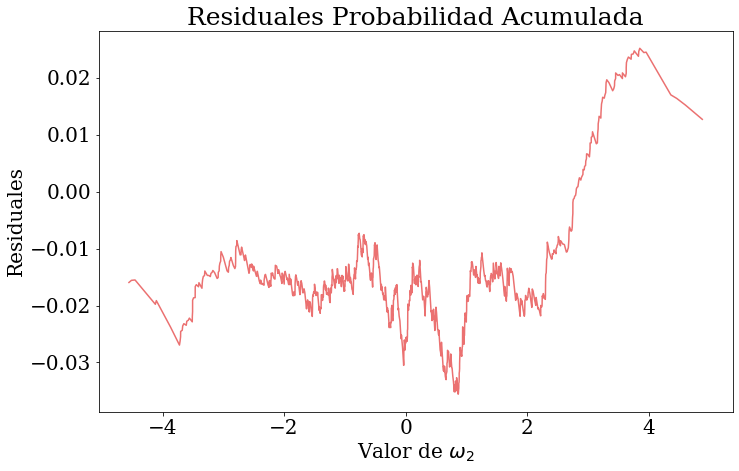

In [29]:
f=plt.figure(figsize=(25,7))
yvech=n(xvec,r)
chisexp=sum((yvec-yvech)**2)/(1000)

ax1 = f.add_subplot(121)
ax1.set_title("Residuales Probabilidad Acumulada",fontsize=25)

ax1.plot(xvec,yvec-yvech,color=(0.9,0.3,0.3,0.8),linewidth=1.5)
ax1.set_xlim(-0.5+min(xvec),0.5+max(xvec))
ax1.set_xlabel("Valor de $\omega_2$",fontsize=20)
ax1.set_ylabel("Residuales",fontsize=20)
ax1.tick_params(labelsize=20)


## 3.9. Metrópolis-Hastings con $r$ (valor 0.3)

Utilizando el valor de $r$ hallado en el punto **3.7**, use el **método de Metrópolis-Hastings** para hallar 10001 puntos que se comporten según la distribución:
$$
f(x)=\frac{r\ee^{-rx}}{(1+\ee^{-rx})^2}\;.
\tag{2}
$$
Debe notarse que la función $f(x)$ **ya está normalizada**. Por otro lado, se recomienda que el valor inicial del camino aleatorio del método se escoja en el intervalo $\pas{-4,4}$. Guarde estos 10001 datos en un `array` llamado `walk`.

In [30]:
r=popt
f=lambda x: (r*np.exp(-r*x))/((1+np.exp(-r*x))**2)
xmin,xmax=-4,4
Nmax=10001
walk=[]
walk.append(np.random.rand()*(xmax-xmin)+xmin)
for i in range(Nmax):
    x= rd.random()*2-1
    alpha=f(x+walk[-1])/f(walk[-1])
    
    if alpha >= 1.0:
        walk.append(x+walk[-1])
    else:
        beta= rd.random()
        if (beta <= alpha):
            walk.append(x+walk[-1])
        else:
            walk.append(walk[-1])
walk=np.array(walk)        

## 3.10. Histogramas de comparación (valor 0.3)

Genere dos gráficas con histogramas de comparación tal como se muestra en el archivo compartido `histogramas.png`. Note que se trata de dos gráficas y se recomienda usar la función `plt.subplots` para que se grafiquen correctamente. El histograma de la derecha se elabora con `xvec` y el de la izquierda con `walk`. Las gráficas deben cumplir los siguientes requisitos:
1. Los `subplots` deben quedar en un arreglo de una fila y dos columnas.
2. Los títulos y etiquetas de eje deben ser como los mostrados en `histogramas.png`.
3. Debe haber 19 barras, con borde negro y el rango de histograma debe estar en el intervalo $\pas{-4.4,4.4}$.
4. Los histogramas deben estar normalizados y se debe superponer en rojo la curva teórica descrita por la ecuación (2) del punto **3.9**.

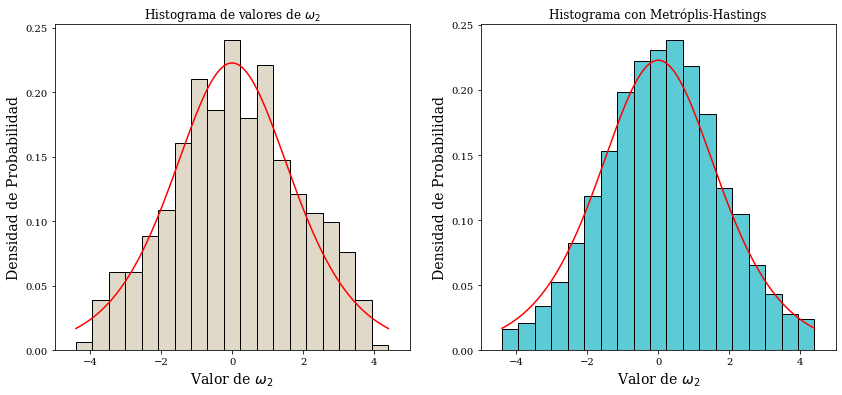

In [31]:
xx=np.linspace(-4.4,4.4,10001)


fig = plt.figure(figsize=(14,6))
hist1 = fig.add_subplot(121)
hist1.set_xlim(-5,5)
hist1.hist(xvec,bins=19,range=(-4.4,4.4),density=True,color=(0.8,0.75,0.65,0.6),edgecolor="k")
hist1.set_title("Histograma de valores de $\omega_2$")
hist1.set_xlabel("Valor de $\omega_2$",fontsize=14)
hist1.set_ylabel("Densidad de Probabilidad",fontsize=14)
hist1.plot(xx,f(xx),color='r',linewidth=1.5)



hist2 = fig.add_subplot(122)
hist2.set_xlim(-5,5)
hist2.set_title("Histograma con Metróplis-Hastings")
hist2.set_xlabel("Valor de $\omega_2$",fontsize=14)
hist2.set_ylabel("Densidad de Probabilidad",fontsize=14)
hist2.hist(walk,bins=19,range=(-4.4,4.4),density=True,color=(0.2,0.75,0.8,0.8),edgecolor="k")
hist2.plot(xx,f(xx),color='r',linewidth=1.5)
fig.show()

